# Tilable terrain gan

- DC GAN for now
- pending tiling features

In [2]:
%pip install tensorflow h5py pyyaml rasterio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-09-30 05:52:47.703602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 05:52:51.023690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 05:52:51.062757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-

In [4]:
import rasterio
import glob
import numpy as np
import random

# Constants
BUFFER_SIZE = 10000
BATCH_SIZE = 32
IMAGE_SIZE = 28
MAX_ALTITUDE = 1105
MIN_ALTITUDE = -23

# 1. Read the GeoTIFF files
file_list = glob.glob("TesisCode/Dataset/download2/*.tif")
ds = tf.data.Dataset.from_tensor_slices(file_list)

# 2. Decode and preprocess the images
def decode_image(filename):
    with rasterio.open(filename.numpy().decode('utf-8')) as src:
        image = src.read()
        image = image[0]
        
    # Resize to desired image size using TensorFlow
    size_rows, size_cols = np.shape(image)
    # random 28x28 crop of np array image
    start_row = random.randint(0, size_rows - IMAGE_SIZE)
    start_col = random.randint(0, size_cols - IMAGE_SIZE)
    image = image[start_row:start_row+IMAGE_SIZE, start_col:start_col+IMAGE_SIZE]

    # Normalize the pixel values to [0,1]
    image = (image - MIN_ALTITUDE) / (MAX_ALTITUDE - MIN_ALTITUDE)
    
    # reshape to 28x28x1
    image = np.expand_dims(image, axis=-1)

    # Convert to float32
    image = tf.cast(image, tf.float32)

    return image

# Use tf.py_function to call the rasterio function in a tensorflow map function
def tf_decode_image(filename):
    return tf.py_function(decode_image, [filename], tf.float32)

ds = ds.map(tf_decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds = ds.cache()

# Use repeat() to loop over the dataset indefinitely
ds = ds.repeat()

# Shuffle and batch the dataset as before
ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


2023-09-30 05:52:51.315750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 05:52:51.315941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 05:52:51.316078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
ds.element_spec
ds.as_numpy_iterator().next()[0].shape


(28, 28, 1)

##  2. Viz data and build dataset

In [6]:
# do data transformation
import numpy as np

In [7]:
# setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [8]:
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

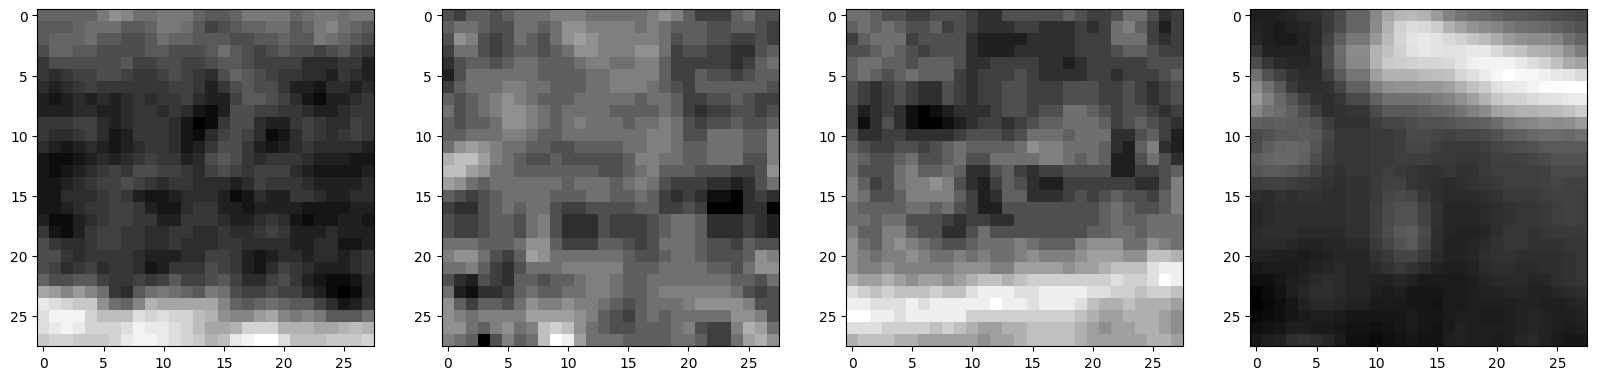

In [9]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
sample = dataiterator.next()
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample[idx]), cmap='gray')

## Build NN

In [10]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [11]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [14]:
img = generator.predict(np.random.randn(4, 128, 1))

2023-09-30 05:52:55.438638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-30 05:52:55.517999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 12ms/step


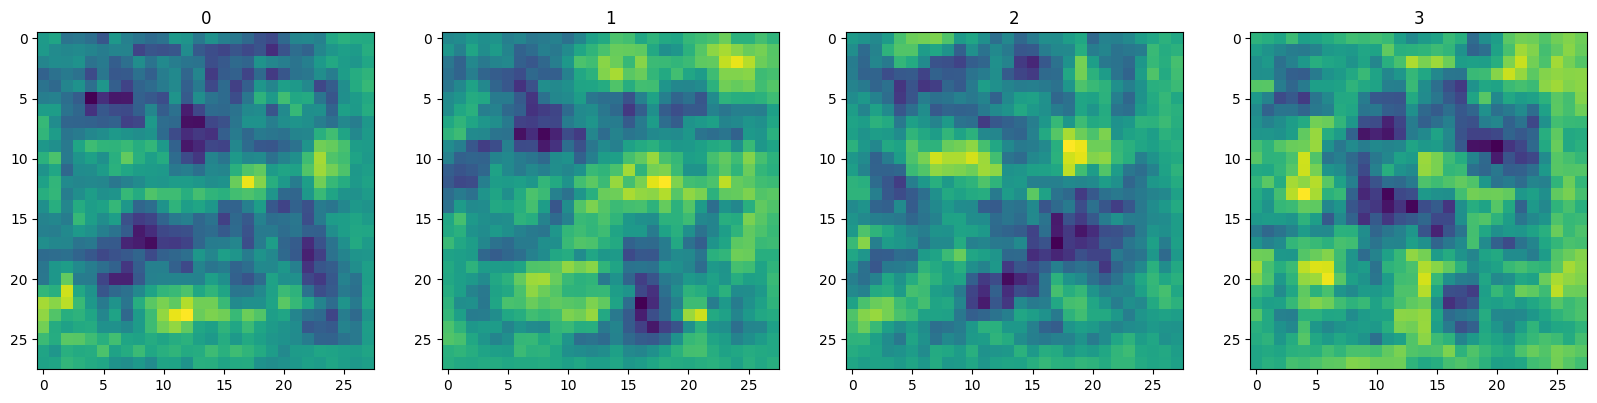

In [15]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [16]:
def build_discriminator():
    model = Sequential()

    # first conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4)) # Might be best to not have
    model.add(Dense(1, activation='sigmoid'))

    return model

In [17]:
discriminator = build_discriminator()

In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

 dropout_2 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 256)       819456    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 12, 12, 256)       0         
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 256)       0         
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dropout_4 (Dropout)         (None, 36864)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 36865     
                                                                 
Total params: 1113345 (4.25 MB)
Trainable params: 1113345 (4.25 MB)
Non-trai

In [19]:
## Pass generated iamge into discriminator to prototype ;)
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 1s 666ms/step


array([[0.5031432]], dtype=float32)

# 4. Construct training loop

# 4.1 Setup losses and optimizers

In [20]:
# Optimizer for both
from tensorflow.keras.optimizers import Adam
# Loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 4.2 Subclass model

In [22]:
# Import base model class to subclass our training step
from tensorflow.keras.models import Model

In [23]:
# 3 key functions

class TerrainTileGan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass to base class
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen end disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        ## Compile w/ baseclass
        super().compile(*args, **kwargs)

        # Attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # get the data
        real_images = batch
        # 128 because we start with a linear layer w/ 128 neurons. Gets reshaped lated
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            # 1. pass real and fake imgs to discriminaotr
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # 2. cresate labels for real and fakes
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # 3. add noise to output to avoid learning too fast
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            ## Not sure if - is good idea.
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # 4. Calculate loss - BINARYCROSSENTROPY
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # 5. Backpropagate -- nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train gen
        with tf.GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss (rewared when disc says fake is real - hence zeros)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            # No need to pass real images bc we're not training discriminator

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}
            
    # Also option for train_test

In [24]:
## Alt
# @tf.function
# def train_step():
#     pass

In [25]:
# Create instance of subclassed model
terrainTileGan = TerrainTileGan(generator, discriminator)

In [26]:
# Compile model
terrainTileGan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build callback

In [27]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [28]:
## Create images dir for model
!mkdir -p images

In [29]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
            tf.summary.image(f'generated_img_{epoch}_{i}', generated_images[i], step=epoch)

## Train

In [30]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Cresate checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verboxe=1)

In [31]:
## Setup tensorboard

from tensorflow.keras.callbacks import TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=1, write_graph=True, write_images=True)

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3977583107050872219
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10264117248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1099813196871280625
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2023-09-30 05:52:59.107761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 05:52:59.108115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-30 05:52:59.108361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [37]:
import os

for i in range(3):
    if os.path.exists(checkpoint_path):
        terrainTileGan.load_weights(checkpoint_path)
    else:
        print("Checkpoint file not found.")
    hist = terrainTileGan.fit(ds, epochs=20, steps_per_epoch=500, callbacks=[ModelMonitor(), cp_callback, tensorboard])

    imgs = generator.predict(tf.random.normal((16, 128, 1)))
    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
    for r in range(4): 
        for c in range(4): 
            ax[r][c].imshow(imgs[(r+1)*(c+1)-1])


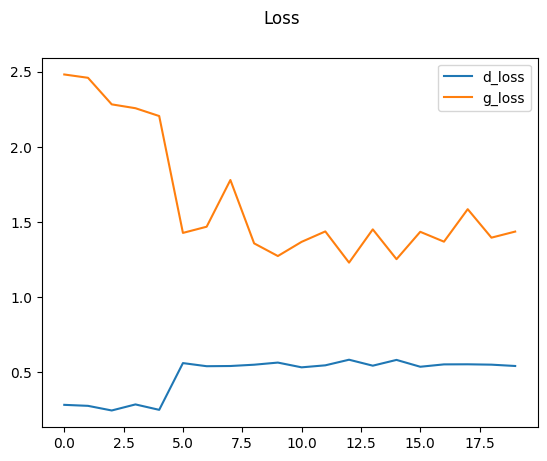

In [34]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

##  5. Test out generator

### 5.1 Generate Images

In [35]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 12ms/step


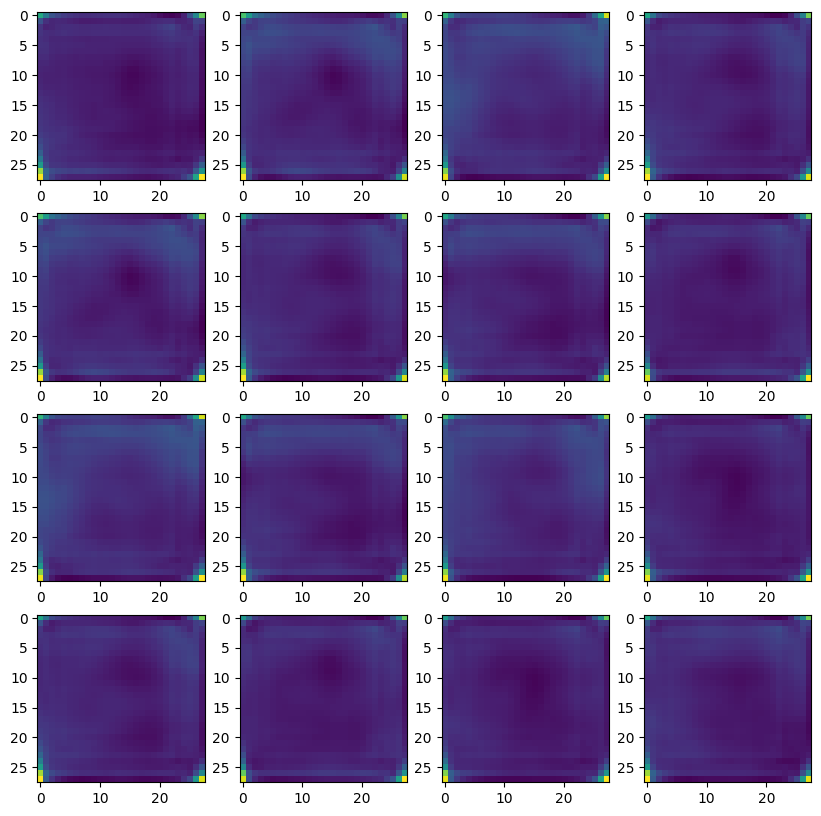

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1], cmap="gray")

### 5.2 Save the model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')